In [1]:
import pandas as pd
import numpy as np

# Importación de datos
Se importan los datos de Kaggle. Fuente: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml?resource=download&select=LI-Medium_Trans.csv

In [2]:
df = pd.read_csv('/home/fernando/prueba_bancoomeva/data/LI-Small_Trans.csv')
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:08,11,8000ECA90,11,8000ECA90,3195403.00,US Dollar,3195403.00,US Dollar,Reinvestment,0
1,2022/09/01 00:21,3402,80021DAD0,3402,80021DAD0,1858.96,US Dollar,1858.96,US Dollar,Reinvestment,0
2,2022/09/01 00:00,11,8000ECA90,1120,8006AA910,592571.00,US Dollar,592571.00,US Dollar,Cheque,0
3,2022/09/01 00:16,3814,8006AD080,3814,8006AD080,12.32,US Dollar,12.32,US Dollar,Reinvestment,0
4,2022/09/01 00:00,20,8006AD530,20,8006AD530,2941.56,US Dollar,2941.56,US Dollar,Reinvestment,0


In [3]:
df.isna().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

Los datos no presentan datos faltantes

In [4]:
df[['Payment Format', 'Is Laundering']].value_counts().sort_index()

Payment Format  Is Laundering
ACH             0                 793970
                1                   2611
Bitcoin         0                 309098
                1                    110
Cash            0                 655564
                1                    124
Cheque          0                2502699
                1                    459
Credit Card     0                1780128
                1                    261
Reinvestment    0                 650458
Wire            0                 228567
Name: count, dtype: int64

In [5]:
df["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.948513
1     0.051487
Name: proportion, dtype: float64

# Fraude por Payment format
Se observa que, dentro del dataset analizado, el canal con mayor número de transacciones etiquetadas como lavado es ACH (Automated Clearing House). En contraste, Wire (transferencias bancarias) y Reinvestment no presentan casos etiquetados como lavado en esta muestra.

En un entorno real, este comportamiento podría deberse a: (i) baja representatividad, (ii) sesgos de etiquetado o (iii) ausencia real de casos detectados, por lo que no se asume que estos canales sean “imposibles” de usar para Lavado. Por esa razón, no se eliminan del dataset en esta prueba; se mantienen para evitar introducir sesgos y para asegurar consistencia y generalización del modelo.

In [6]:
#Renombrar columnas Account
df.rename(columns={'Account': 'Account Origin', 'Account.1': 'Account Destination'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6924049 entries, 0 to 6924048
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Timestamp            object 
 1   From Bank            int64  
 2   Account Origin       object 
 3   To Bank              int64  
 4   Account Destination  object 
 5   Amount Received      float64
 6   Receiving Currency   object 
 7   Amount Paid          float64
 8   Payment Currency     object 
 9   Payment Format       object 
 10  Is Laundering        int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 581.1+ MB


In [8]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df = df.dropna(subset=["Timestamp"])

print(df.shape)
print(df["Is Laundering"].value_counts(dropna=False))
print(df["Timestamp"].min(), df["Timestamp"].max())

(6924049, 11)
Is Laundering
0    6920484
1       3565
Name: count, dtype: int64
2022-09-01 00:00:00 2022-09-17 15:28:00


# Ordenar dataset
se selcciona la columna `Tiemstamp` para realizar un ordenamiento del dataset y tener el último 20% como datos de prueba, simulando un entorno real.

In [9]:
df = df.sort_values("Timestamp")
cut = int(len(df)*0.8)
train_raw = df.iloc[:cut].copy()
test_raw  = df.iloc[cut:].copy()

# Conjunto de entrenamiento
Con el fin de tener datos más balanceados, se genera un data set con una relación 1:200 entre valores positivos y negativos.

In [10]:
pos = train_raw[train_raw["Is Laundering"]==1]
neg = train_raw[train_raw["Is Laundering"]==0]

neg_s = neg.sample(n=min(len(neg), len(pos)*200), random_state=42)

train = pd.concat([pos, neg_s], ignore_index=True).sample(frac=1, random_state=42)
print(train["Is Laundering"].value_counts(normalize=True)*100)

Is Laundering
0    99.502488
1     0.497512
Name: proportion, dtype: float64


In [11]:
def add_basic_features(d):
    d = d.copy()
    d["hora"] = d["Timestamp"].dt.hour
    d["dia"]  = d["Timestamp"].dt.dayofweek
    d["is_fds"] = (d["dia"]>=5).astype(int)

    d["log_paid"] = np.log1p(d["Amount Paid"].clip(lower=0))
    d["log_recv"] = np.log1p(d["Amount Received"].clip(lower=0))

    d["fx_flag"] = (d["Payment Currency"] != d["Receiving Currency"]).astype(int)
    d["dif_bank_flag"] = (d["From Bank"] != d["To Bank"]).astype(int)

    d["paid_minus_received"] = d["Amount Paid"] - d["Amount Received"]
    d["abs_paid_minus_received"] = np.abs(d["paid_minus_received"])
    return d

train = add_basic_features(train)
test  = add_basic_features(test_raw)


In [12]:
origin_stats = train.groupby("Account Origin").agg(
    origin_mean_paid=("Amount Paid","mean"),
    origin_std_paid=("Amount Paid","std"),
    origin_txn_count=("Amount Paid","size"),
).reset_index()

train = train.merge(origin_stats, on="Account Origin", how="left")
test  = test.merge(origin_stats,  on="Account Origin", how="left")

train["origin_std_paid"] = train["origin_std_paid"].fillna(0)
test["origin_std_paid"]  = test["origin_std_paid"].fillna(0)

In [13]:
eps = 1e-6
train["z_paid_vs_origin"] = (train["Amount Paid"] - train["origin_mean_paid"]) / (train["origin_std_paid"] + eps)
test["z_paid_vs_origin"]  = (test["Amount Paid"] - test["origin_mean_paid"]) / (test["origin_std_paid"] + eps)

test["origin_unseen_flag"] = test["origin_mean_paid"].isna().astype(int)
train["origin_unseen_flag"] = 0

In [14]:
pairs = train[["Account Origin","Account Destination"]].drop_duplicates()
pairs["seen_pair"] = 1

test = test.merge(pairs, on=["Account Origin","Account Destination"], how="left")
train = train.merge(pairs, on=["Account Origin","Account Destination"], how="left")

test["new_dest_flag"]  = test["seen_pair"].isna().astype(int)
train["new_dest_flag"] = train["seen_pair"].isna().astype(int)

train.drop(columns=["seen_pair"], inplace=True, errors="ignore")
test.drop(columns=["seen_pair"], inplace=True, errors="ignore")

In [15]:
test["z_paid_vs_origin"] = test["z_paid_vs_origin"].fillna(0)
test["origin_txn_count"] = test["origin_txn_count"].fillna(0)

In [16]:
train.head()

,Timestamp,From Bank,Account Origin,To Bank,Account Destination,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,fx_flag,dif_bank_flag,paid_minus_received,abs_paid_minus_received,origin_mean_paid,origin_std_paid,origin_txn_count,z_paid_vs_origin,origin_unseen_flag,new_dest_flag
0,2022-09-06 07:15:00,19229,80BB35461,33747,817C7DA31,1.396454,Bitcoin,1.396454,Bitcoin,Bitcoin,...,0,1,0.0,0.0,1.396454,0.00000,2,0.00000,0,0
1,2022-09-01 00:29:00,42275,80F8F7190,42275,80F8F7190,142230.190000,Australian Dollar,142230.190000,Australian Dollar,Reinvestment,...,0,0,0.0,0.0,142230.190000,0.00000,1,0.00000,0,0
2,2022-09-06 18:32:00,65259,819A8DDA0,137029,81BD80DD0,11110.810000,US Dollar,11110.810000,US Dollar,Cheque,...,0,1,0.0,0.0,7415.356667,6400.71293,3,0.57735,0,0
3,2022-09-03 00:01:00,113,81121C0B0,113,810E816F0,419.550000,Mexican Peso,419.550000,Mexican Peso,Credit Card,...,0,0,0.0,0.0,419.550000,0.00000,1,0.00000,0,0
4,2022-09-05 18:24:00,24027,805AC2070,10881,806E39F50,297.810000,Euro,297.810000,Euro,Cheque,...,0,1,0.0,0.0,297.810000,0.00000,3,0.00000,0,0


In [17]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import average_precision_score, roc_auc_score

In [18]:
target = "Is Laundering"

cat_cols = ["Account Origin","Account Destination","Receiving Currency",
            "Payment Currency","Payment Format"]
drop_cols = ["Timestamp"]

feat_cols = [c for c in train.columns if c not in [target] + drop_cols]

X_train, y_train = train[feat_cols], train[target]
X_test,  y_test  = test[feat_cols],  test[target]

train_pool = Pool(X_train, y_train, cat_features=[X_train.columns.get_loc(c) for c in cat_cols])
test_pool  = Pool(X_test,  y_test,  cat_features=[X_test.columns.get_loc(c) for c in cat_cols])

model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=100,
    random_seed=42,
    class_weights=[1, max(1, int((y_train==0).sum()/(y_train==1).sum()))]  
)

model.fit(train_pool, eval_set=test_pool)

proba = model.predict_proba(test_pool)[:,1]
print("PR-AUC:", average_precision_score(y_test, proba))
print("ROC-AUC:", roc_auc_score(y_test, proba))

0:	test: 0.9234414	best: 0.9234414 (0)	total: 823ms	remaining: 6m 50s
100:	test: 0.9648474	best: 0.9654738 (84)	total: 35.2s	remaining: 2m 19s
200:	test: 0.9624248	best: 0.9654738 (84)	total: 1m 11s	remaining: 1m 46s
300:	test: 0.9536103	best: 0.9654738 (84)	total: 1m 49s	remaining: 1m 12s
400:	test: 0.9508684	best: 0.9654738 (84)	total: 2m 26s	remaining: 36.2s
499:	test: 0.9467542	best: 0.9654738 (84)	total: 3m 3s	remaining: 0us

bestTest = 0.9654738356
bestIteration = 84

Shrink model to first 85 iterations.
PR-AUC: 0.055484239341049756
ROC-AUC: 0.9654738355563641


In [19]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix
)

# 1) Umbral
threshold = 0.65

# 2) Predicción binaria
y_pred = (proba >= threshold).astype(int)

# 3) Métricas 
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

# 4) Métricas por score 
roc  = roc_auc_score(y_test, proba)
prauc = average_precision_score(y_test, proba) 


print("\nConfusion matrix [ [TN, FP], [FN, TP] ]:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))



Confusion matrix [ [TN, FP], [FN, TP] ]:
[[1191157  192728]
 [     43     882]]

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.8607    0.9251   1383885
           1     0.0046    0.9535    0.0091       925

    accuracy                         0.8608   1384810
   macro avg     0.5023    0.9071    0.4671   1384810
weighted avg     0.9993    0.8608    0.9245   1384810



Confusion Matrix (labels 0,1):
 [[1191157  192728]
 [     43     882]]


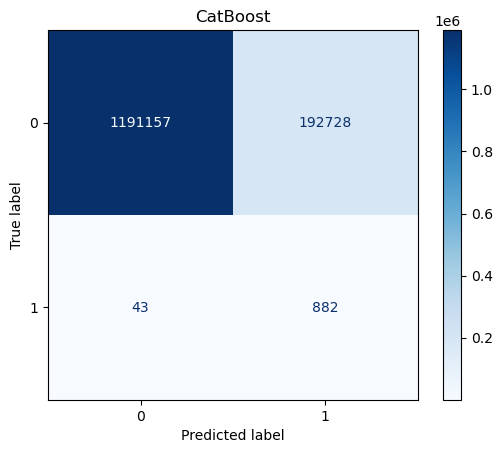

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import  ConfusionMatrixDisplay

y_pred = (proba >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
print("Confusion Matrix (labels 0,1):\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues",  values_format='d')
plt.title(f"CatBoost")
plt.show()


In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)

target = "Is Laundering"


num_cols = [
    "log_paid","log_recv","abs_paid_minus_received",
    "hora","dia","is_fds",
    "fx_flag","dif_bank_flag",
    "z_paid_vs_origin","origin_txn_count",
    "new_dest_flag","origin_unseen_flag"
]

cat_cols = [
    "Payment Format","Payment Currency","Receiving Currency",
    "From Bank","To Bank"
]

# Asegura tipos correctos
train["From Bank"] = train["From Bank"].astype(str)
train["To Bank"]   = train["To Bank"].astype(str)
test["From Bank"]  = test["From Bank"].astype(str)
test["To Bank"]    = test["To Bank"].astype(str)

X_train = train[num_cols + cat_cols].copy()
y_train = train[target].astype(int).copy()
X_test  = test[num_cols + cat_cols].copy()
y_test  = test[target].astype(int).copy()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler(with_mean=False))  
        ]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("lr", LogisticRegression(
        max_iter=1000,
        class_weight="balanced", 
        solver="saga",            
        n_jobs=-1
    ))
])

clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))

thr = 0.5
y_pred = (proba >= thr).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4, zero_division=0))


/home/fernando/anaconda3/envs/mlpy/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ROC-AUC: 0.8313061120822316
PR-AUC : 0.0023657817775035537
[[1015950  367935]
 [     75     850]]
              precision    recall  f1-score   support

           0     0.9999    0.7341    0.8467   1383885
           1     0.0023    0.9189    0.0046       925

    accuracy                         0.7343   1384810
   macro avg     0.5011    0.8265    0.4256   1384810
weighted avg     0.9993    0.7343    0.8461   1384810



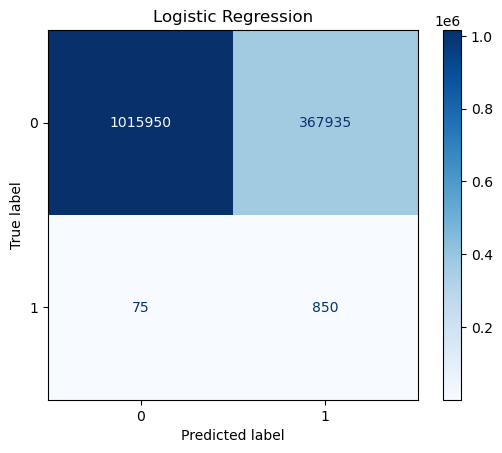

In [22]:
threshold = 0.5
y_pred_lr = (proba >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues",  values_format='d')
plt.title(f"Logistic Regression")
plt.show()